In [11]:
# Copyright 2024 The AI Edge Torch Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

This Colab demonstrates how to convert a PyTorch [IS-Net](https://github.com/xuebinqin/DIS) model to a TensorFlow Lite model using the ai_edge_torch library. It also guides you through running the converted model with MediaPipe's Image Segmentation Task.

# Prerequisites

First install all dependencies.

In [ ]:
!pip install -r https://raw.githubusercontent.com/google-ai-edge/ai-edge-torch/main/requirements.txt
!pip install ai-edge-torch
!pip install pillow requests matplotlib mediapipe

Then download and read the test image.

In [ ]:
!curl -H 'Accept: application/vnd.github.v3.raw'  -O   -L https://api.github.com/repos/google-ai-edge/ai-edge-torch/contents/test/image_segmentation/test_data/astrid_l_shaped.jpg;

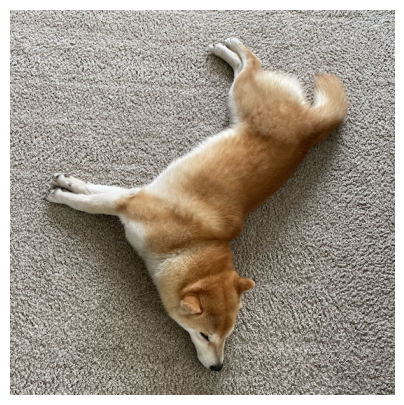

In [31]:
from matplotlib import pyplot as plt
from PIL import Image

IMAGE_PATH = '/content/astrid_l_shaped.jpg'
image = Image.open(IMAGE_PATH)
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(image);

# PyTorch model validation

Clone IS-Net DIS repo and download Pytorch model

In [ ]:
%cd /content
!rm -rf DIS sample_data

# Clone github repo and download the Pytorch model.
!git clone https://github.com/xuebinqin/DIS.git
%cd DIS/IS-Net/

!curl -o ./model.tar.gz -L https://www.kaggle.com/api/v1/models/paulruiz/dis/pyTorch/8-17-22/1/download
!tar -xvf 'model.tar.gz'

Build model

In [15]:
import torch
from models import ISNetDIS


pytorch_model_filename = 'isnet-general-use.pth'
pt_model = ISNetDIS()
pt_model.load_state_dict(
    torch.load(pytorch_model_filename, map_location=torch.device('cpu')))
pt_model.eval();

Prepare inputs

In [16]:
from io import BytesIO
import numpy as np
from skimage import io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms.functional import normalize


input_size=[1024, 1024]

im = io.imread(IMAGE_PATH)
if len(im.shape) < 3:
  im = im[:, :, np.newaxis]
im_shp = im.shape[0:2]

im_tensor = torch.tensor(im, dtype=torch.float32).permute(2, 0, 1)
im_tensor = F.upsample(torch.unsqueeze(im_tensor, 0),
                       input_size, mode='bilinear').type(torch.uint8)
pt_image = torch.divide(im_tensor, 255.0)
pt_image = normalize(pt_image, mean=[0.5, 0.5, 0.5], std=[1.0, 1.0, 1.0])

Get prediction

In [17]:
pt_ds_val = pt_model(pt_image)[0]  # List of 6 results.
pt_pred_val = pt_ds_val[0]  # First one has the most accurate prediction.

# Recover the prediction spatial size to the orignal image size.
pt_result = torch.squeeze(F.upsample(pt_pred_val, im_shp,  mode='bilinear'), 0)
ma = torch.max(pt_result)
mi = torch.min(pt_result)
pt_result = (pt_result - mi) / (ma - mi)
pt_result = (pt_result * 255).permute(1, 2, 0).cpu().data.numpy().astype(np.uint8)

Show the result segmentation mask

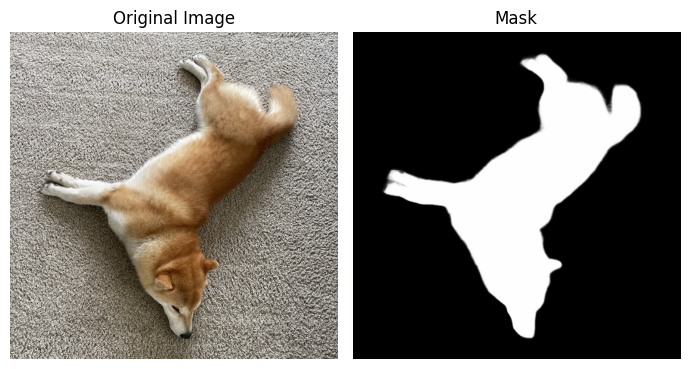

In [18]:
from matplotlib import pyplot as plt


f, ax = plt.subplots(1, 2, figsize = (7,7))
ax[0].imshow(im)  # Original image.
ax[1].imshow(pt_result, cmap = 'gray')  # Segmentation mask.
ax[0].set_title('Original Image')
ax[1].set_title('Mask')
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout()
plt.show()

### IS-Net DIS to TFLite conversion

In [19]:
import torch
from torch import nn
from torchvision.transforms.functional import normalize
import torch.nn.functional as F


class PT2MP_ImageSegmentationModelWrapper(nn.Module):
  def __init__(self, pt_model):
    super().__init__()
    self.model = pt_model

  def forward(self, image: torch.Tensor):
    # BHWC -> BCHW.
    image = image.permute(0, 3, 1, 2)

    # Get result.
    result = self.model(image)[0][0]

    # TODO: b/336805255 - Add min-max normalization postprocessing step.
    # In official model Colab demo
    # (https://github.com/xuebinqin/DIS/blob/main/Colab_Demo.ipynb) next model
    # output should be min-max normalized. Currently skipping this step, because
    # torch.min and torch.max are not supported.
    # ma = torch.max(result)
    # mi = torch.min(result)
    # result = (result - mi) / (ma - mi)

    # Output has shape [1 x 1 x 1024 x 1024] for [batch x channel x H x W].
    # Media Pipe Image Segmenter expects [batch x H x W x class]. This model
    # produces predictions for a single class, so just dimension permutation is
    # enough.
    result = result.permute(0, 2, 3, 1)

    return result


wrapped_pt_model = PT2MP_ImageSegmentationModelWrapper(pt_model).eval()

Provide sample arguments -- result TFLite model will expect input of this size -- and convert the model.

In [ ]:
import ai_edge_torch


sample_args = (torch.rand((1, 1024, 1024, 3)),)
edge_model = ai_edge_torch.convert(wrapped_pt_model, sample_args)

Get model buffer.

In [21]:
from pathlib import Path


flatbuffer_file = Path('isnet_mp_image_segmentation_raw.tflite')
edge_model.export(flatbuffer_file)

In [22]:
tflite_model_buffer = flatbuffer_file.read_bytes()

Populate the metadata. IS-Net expects inputs normalized with mean 0.5 and std 1.0. Let Media Pipe Task to handle it by providing the corresponding values for uint8 images.

In [23]:
from mediapipe.tasks.python.metadata.metadata_writers import image_segmenter
from mediapipe.tasks.python.metadata.metadata_writers import metadata_writer


writer = image_segmenter.MetadataWriter.create(
    tflite_model_buffer,
    input_norm_mean=[127.5],
    input_norm_std=[255.0],
)
tflite_model_buffer, _ = writer.populate()

Currently, passing the converted model buffer to the MP segmenter results in an out-of-memory error, indicated by the message:

```Your session crashed after using all available RAM.```

To mitigate this problem, a workaround is to save the model to a file and use that file instead.

In [24]:
tflite_filename = 'isnet_mp_image_segmentation.tflite'
tflite_path = f'/content/{tflite_filename}'
# Save converted model to Colab's local file system.
with open(tflite_path, 'wb') as f:
  f.write(tflite_model_buffer)

Check that the file was successefully saved.

In [ ]:
!ls -l /content/isnet_mp_image_segmentation.tflite

# Validate converted model with MediaPipe Tasks

In [ ]:
import numpy as np
from PIL import Image
import mediapipe as mp
from mediapipe.tasks.python.vision.image_segmenter import ImageSegmenter


tfl_image = Image.open(IMAGE_PATH)
tfl_np_image = np.array(tfl_image.resize((1024, 1024),
                                         Image.Resampling.BILINEAR))

tflite_filename = 'isnet_mp_image_segmentation.tflite'
tflite_path = f'/content/{tflite_filename}'
options = mp.tasks.vision.ImageSegmenterOptions(
    base_options=mp.tasks.BaseOptions(
        model_asset_path=tflite_path),
    output_category_mask=True)

# TODO: b/336806051 - Fix inverted mask issue.
# Currently MP Image Segmenter with converted model returns mask, which is
# similar to PyTorch model output, but inverted.
with ImageSegmenter.create_from_options(options) as segmenter:
  mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=tfl_np_image)
  segmentation_result = segmenter.segment(mp_image)

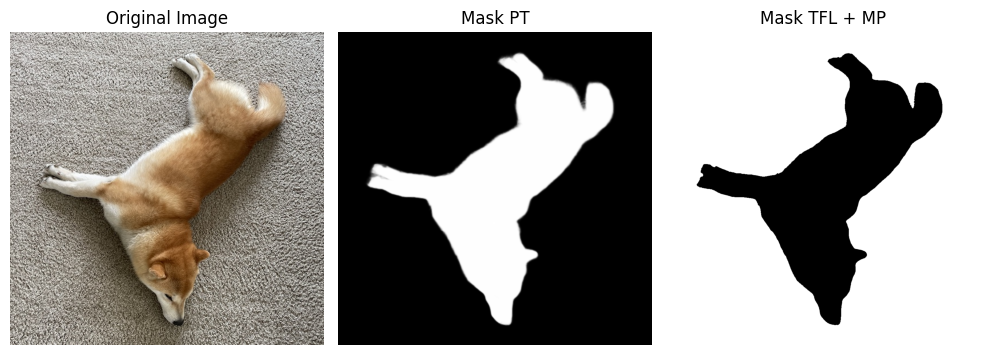

In [27]:
from matplotlib import pyplot as plt


pt_result_image = Image.fromarray(pt_result[:,:,0]).resize((1024, 1024), Image.Resampling.BILINEAR)

f, ax = plt.subplots(1, 3, figsize = (10,10))
ax[0].imshow(tfl_image)  # Original image.
ax[1].imshow(pt_result_image, cmap = 'gray')  # Segmentation mask PT.
ax[2].imshow(segmentation_result.category_mask.numpy_view(), cmap = 'gray')  # Segmentation mask TFL + MP.
ax[0].set_title('Original Image')
ax[1].set_title('Mask PT')
ax[2].set_title('Mask TFL + MP')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.tight_layout()
plt.show()

# Download converted model

In [ ]:
from google.colab import files


files.download(tflite_path)